In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import mutual_info_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np

/Users/laureneterno/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
clothing = pd.read_csv('clean_clothing.csv')

In [3]:
clothing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532 entries, 0 to 1531
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        1532 non-null   float64
 1   units_sold                   1532 non-null   int64  
 2   uses_ad_boosts               1532 non-null   int64  
 3   rating                       1532 non-null   float64
 4   rating_count                 1532 non-null   int64  
 5   rating_five_count            1532 non-null   float64
 6   rating_four_count            1532 non-null   float64
 7   rating_three_count           1532 non-null   float64
 8   rating_two_count             1532 non-null   float64
 9   rating_one_count             1532 non-null   float64
 10  badges_count                 1532 non-null   int64  
 11  badge_local_product          1532 non-null   int64  
 12  badge_product_quality        1532 non-null   int64  
 13  badge_fast_shippin

In [4]:
units_sold = clothing['units_sold']
clothing = clothing.drop(columns=['product_color', 'units_sold'])

# Clustering

/var/folders/g4/ysfgx68s4mjfkjy9mfw343100000gn/T/ipykernel_21326/821754773.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cluster'] = kmeans.fit_predict(preprocessor.fit_transform(train_data))
/var/folders/g4/ysfgx68s4mjfkjy9mfw343100000gn/T/ipykernel_21326/821754773.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['PCA1'] = pca_result_train[:, 0]
/var/folders/g4/ysfgx68s4mjfkjy9mfw343100000gn/T/ipykernel_21326/821754773.py:20: SettingWithCopyWarning: 
A value is trying to b

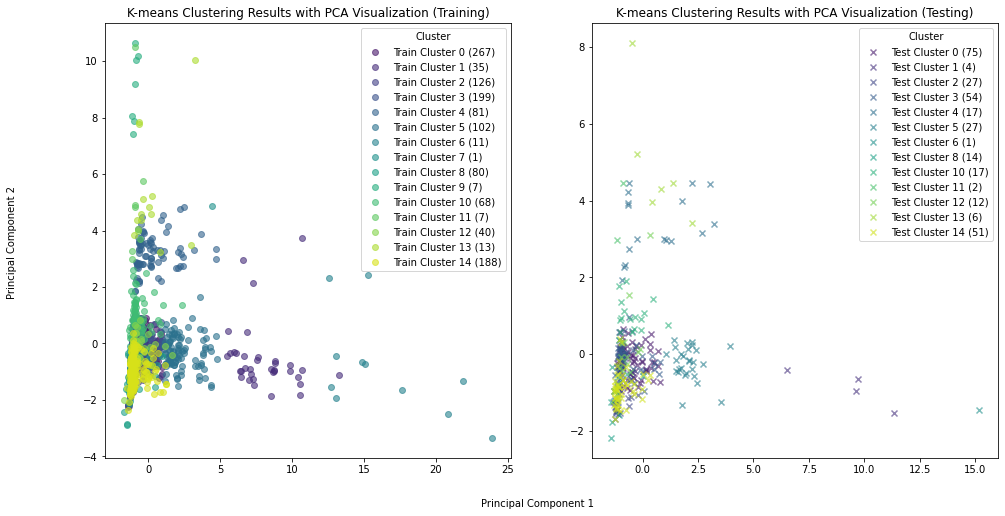

15
0     342
3     253
14    239
2     153
5     129
4      98
8      94
10     85
12     52
1      39
13     19
6      12
11      9
9       7
7       1
Name: cluster, dtype: int64


In [5]:
# split the data into training and testing
train_data, test_data = train_test_split(clothing, test_size=0.2, random_state=42)

# standardize numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), clothing.columns),
    ])

# Fit and transform the original features with PCA for training data
pca = PCA()
pca_result_train = pca.fit_transform(preprocessor.fit_transform(train_data))

# k-means model
kmeans = KMeans(n_clusters=15, random_state=42)
train_data['cluster'] = kmeans.fit_predict(preprocessor.fit_transform(train_data))

# PCA for training
train_data['PCA1'] = pca_result_train[:, 0]
train_data['PCA2'] = pca_result_train[:, 1]

# transform the testing data
pca_result_test = pca.transform(preprocessor.transform(test_data))
test_data['cluster'] = kmeans.predict(preprocessor.transform(test_data))
test_data['PCA1'] = pca_result_test[:, 0]
test_data['PCA2'] = pca_result_test[:, 1]

# add the columns to clothing dataframe
clothing['cluster'] = pd.concat([train_data['cluster'], test_data['cluster']])
clothing['PCA1'] = pd.concat([train_data['PCA1'], test_data['PCA1']])
clothing['PCA2'] = pd.concat([train_data['PCA2'], test_data['PCA2']])

# get the cluster labels for each set
unique_clusters_train, counts_train = train_data['cluster'].value_counts().sort_index().index, train_data['cluster'].value_counts().sort_index()
unique_clusters_test, counts_test = test_data['cluster'].value_counts().sort_index().index, test_data['cluster'].value_counts().sort_index()

# give each cluster its own color
colors_train = sns.color_palette('viridis', n_colors=len(unique_clusters_train))
colors_test = sns.color_palette('viridis', n_colors=len(unique_clusters_test))

# create subplots for the training and testing data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# make scatter plot for training
ax1.set_title('K-means Clustering Results with PCA Visualization (Training)')
for cluster, color in zip(unique_clusters_train, colors_train):
    cluster_data = train_data[train_data['cluster'] == cluster]
    ax1.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Train Cluster {cluster} ({counts_train[cluster]})', alpha=0.6, color=color)

# make scatter plot for testing
ax2.set_title('K-means Clustering Results with PCA Visualization (Testing)')
for cluster, color in zip(unique_clusters_test, colors_test):
    cluster_data = test_data[test_data['cluster'] == cluster]
    ax2.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Test Cluster {cluster} ({counts_test[cluster]})', alpha=0.6, marker='x', color=color)

# add legends
ax1.legend(title='Cluster')
ax2.legend(title='Cluster')

# set labels
fig.text(0.5, 0.04, 'Principal Component 1', ha='center')
fig.text(0.04, 0.5, 'Principal Component 2', va='center', rotation='vertical')

plt.show()

# get the number of clusters and the nodes in each cluster
print(clothing['cluster'].nunique())  
print(clothing['cluster'].value_counts())

# Grouping by Units Sold

In [6]:
clothing['units_sold'] = units_sold

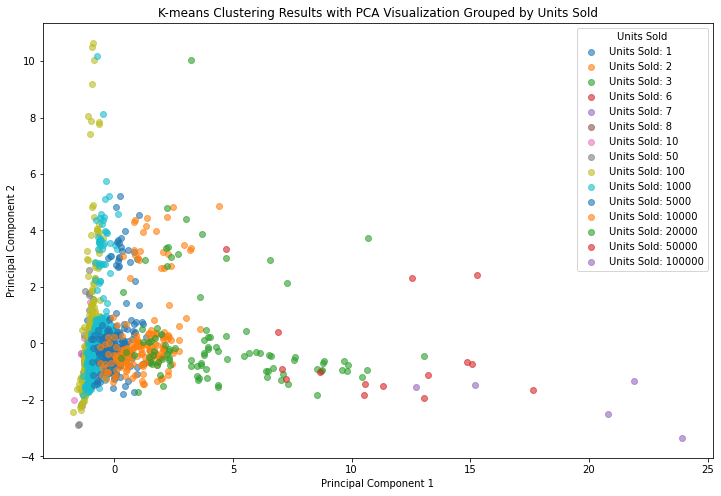

In [7]:
# Group the data by 'units_sold'
grouped_data = clothing.groupby('units_sold')

# Create the scatter plot for each group
plt.figure(figsize=(12, 8))
for name, group in grouped_data:
    plt.scatter(group['PCA1'], group['PCA2'], label=f'Units Sold: {name}', alpha=0.6)

# Add legend and labels
plt.legend(title='Units Sold')
plt.title('K-means Clustering Results with PCA Visualization Grouped by Units Sold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

In [8]:
mi_score = mutual_info_score(clothing['units_sold'], clothing['cluster'])
print(f"Mutual Information Score: {mi_score}")

Mutual Information Score: 0.362848305775445


# Evaluate the Clusters

In [9]:
average_units_sold_per_cluster = clothing.groupby('cluster')['units_sold'].mean()

cluster_ranking = average_units_sold_per_cluster.rank(ascending=False)

cluster_units_sold_ranking = pd.DataFrame({
    'Average Units Sold Cluster': average_units_sold_per_cluster,
    'Rank': cluster_ranking,
    'Cluster': average_units_sold_per_cluster.index,
})

# Sort the DataFrame by the 'Rank' column
cluster_units_sold_ranking = cluster_units_sold_ranking.sort_values(by='Rank')

cluster_units_sold_ranking

,Average Units Sold Cluster,Rank,Cluster
cluster,,,
6,68333.333333,1.0,6
1,26153.846154,2.0,1
5,13604.651163,3.0,5
7,10000.000000,4.0,7
4,5581.632653,5.0,4
13,5121.052632,6.0,13
3,2557.233202,7.0,3
0,2292.868421,8.0,0
12,1538.076923,9.0,12


In [10]:
# Get unique values of the 'Category' column
unique_values = clothing['units_sold'].unique()

# Calculate the rank based on the unique values
ranking = pd.Series(unique_values).rank(ascending=False)

# Create a DataFrame to display the result
units_sold_ranking = pd.DataFrame({
    'Average Units Sold Grouping': unique_values,
    'Rank': ranking
})

# Sort the DataFrame by the 'Rank' column
units_sold_ranking = units_sold_ranking.sort_values(by='Rank')

units_sold_ranking

,Average Units Sold Grouping,Rank
7,100000,1.0
4,50000,2.0
1,20000,3.0
6,10000,4.0
2,5000,5.0
5,1000,6.0
0,100,7.0
8,50,8.0
3,10,9.0
13,8,10.0


In [11]:
# Perform inner join on the 'Rank' column
ranking = pd.merge(units_sold_ranking, cluster_units_sold_ranking, on='Rank', how='inner', suffixes=('_df1', '_df2'))
ranking

,Average Units Sold Grouping,Rank,Average Units Sold Cluster,Cluster
0,100000,1.0,68333.333333,6
1,50000,2.0,26153.846154,1
2,20000,3.0,13604.651163,5
3,10000,4.0,10000.000000,7
4,5000,5.0,5581.632653,4
5,1000,6.0,5121.052632,13
6,100,7.0,2557.233202,3
7,50,8.0,2292.868421,0
8,10,9.0,1538.076923,12
9,8,10.0,1491.280335,14


# C-Index

In [12]:
conditions = [clothing['cluster'] == 6, 
              clothing['cluster'] == 1,
              clothing['cluster'] == 5,
              clothing['cluster'] == 7,
              clothing['cluster'] == 4,
              clothing['cluster'] == 13,
              clothing['cluster'] == 3,
              clothing['cluster'] == 0,
              clothing['cluster'] == 12,
              clothing['cluster'] == 14,
              clothing['cluster'] == 10,
              clothing['cluster'] == 2,
              clothing['cluster'] == 8,
              clothing['cluster'] == 11,
              clothing['cluster'] == 9]
values = ranking['Average Units Sold Grouping']
clothing['predicted_units_sold'] = np.select(conditions, values, default=None)
clothing

,price,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,...,shipping_option_price,countries_shipped_to,has_urgency_banner,merchant_rating_count,merchant_rating,cluster,PCA1,PCA2,units_sold,predicted_units_sold
0,16.00,0,3.76,54,26.0,8.0,10.0,1.0,9.0,0,...,4,34,1.0,568,4.128521,10,-0.970261,0.909003,100,7
1,8.00,1,3.45,6135,2269.0,1027.0,1118.0,644.0,1077.0,0,...,2,41,1.0,17752,3.899673,1,7.335867,-1.456214,20000,50000
2,8.00,0,3.57,14,5.0,4.0,2.0,0.0,3.0,0,...,3,36,1.0,295,3.989831,2,-1.221401,-0.523805,100,6
3,8.00,1,4.03,579,295.0,119.0,87.0,42.0,36.0,0,...,2,41,0.0,23832,4.020435,3,-0.365894,-0.246822,5000,100
4,2.72,1,3.10,20,6.0,4.0,2.0,2.0,6.0,0,...,1,35,1.0,14482,4.001588,2,-1.232211,-1.693366,100,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527,6.00,1,4.08,1367,722.0,293.0,185.0,77.0,90.0,0,...,2,41,0.0,5316,4.224605,3,0.518252,-0.192099,10000,100
1528,2.00,1,3.07,28,11.0,3.0,1.0,3.0,10.0,0,...,1,26,1.0,4435,3.696054,2,-1.345953,-2.148711,100,6
1529,5.00,0,3.71,59,24.0,15.0,8.0,3.0,9.0,0,...,2,11,0.0,210,3.961905,14,-1.105091,-0.940045,100,8
1530,13.00,0,2.50,2,0.0,1.0,0.0,0.0,1.0,0,...,3,29,0.0,31,3.774194,8,-1.242781,-0.590123,100,3


In [13]:
def concordance_index(true_values, predicted_scores):
    n = len(true_values)
    assert n == len(predicted_scores), "Lists must have the same length."

    concordant = 0
    discordant = 0
    ties = 0

    for i in range(n):
        for j in range(i + 1, n):
            if true_values[i] != true_values[j]:
                if (predicted_scores[i] < predicted_scores[j] and
                        true_values[i] < true_values[j]):
                    concordant += 1
                elif (predicted_scores[i] > predicted_scores[j] and
                      true_values[i] > true_values[j]):
                    concordant += 1
                elif predicted_scores[i] == predicted_scores[j]:
                    ties += 1
                else:
                    discordant += 1

    c_index = (concordant + 0.5 * ties) / (concordant + discordant + ties)

    return c_index

c_index_value = concordance_index(clothing['units_sold'], clothing['predicted_units_sold'])
print("Concordance Index:", c_index_value)

Concordance Index: 0.7259552134662038


# How many in each cluster comparison

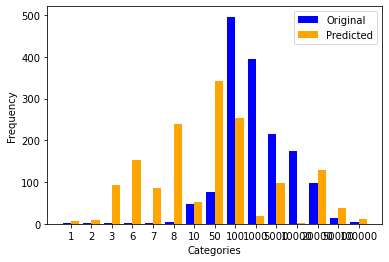

In [14]:
def plot_frequency_comparison(list1, list2, labels=None):
    counter1 = Counter(list1)
    counter2 = Counter(list2)

    categories = sorted(set(counter1) | set(counter2))
    values1 = [counter1[category] for category in categories]
    values2 = [counter2[category] for category in categories]

    x = range(len(categories))

    plt.bar(x, values1, width=-0.4, align='edge', label='Original', color='blue')
    plt.bar(x, values2, width=0.4, align='edge', label='Predicted', color='orange')

    plt.xlabel('Categories')
    plt.ylabel('Frequency')
    plt.xticks(x, labels if labels else categories)
    plt.legend()
    plt.show()

plot_frequency_comparison(clothing['units_sold'], clothing['predicted_units_sold'])